In [1]:
import pyspark.pandas as ps
from pyspark import SparkContext
from pyspark.sql import SparkSession
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

warnings.filterwarnings('ignore')

spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .config("spark.ui.showConsoleProgress", "false") \
    .config("spark.jars", """
            /usr/local/spark/jars/aws-java-sdk-bundle-1.12.262.jar,
            /usr/local/spark/jars/antlr4-runtime-4.9.3.jar,
            /usr/local/spark/jars/delta-contribs_2.12-3.1.0.jar,
            /usr/local/spark/jars/delta-iceberg_2.12-3.1.0.jar,
            /usr/local/spark/jars/delta-spark_2.12-3.1.0.jar,
            /usr/local/spark/jars/delta-storage-3.1.0.jar,
            /usr/local/spark/jars/hadoop-aws-3.3.4.jar""") \
    .appName("SparkTest") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

%load_ext sparksql_magic
%config SparkSql.limit=20

/opt/conda/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
24/08/12 19:04:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
# Leemos el CSV con pandas.spark para tener pandas funcioanando con Spark
data_dir = 's3a://data/new_retail_data.csv'
df = ps.read_csv(data_dir)

In [3]:
# Vemos el tamaño de el dataframe
print(f'El dataset tiene {df.shape[0]} lineas y {df.shape[1]} columnas.')

El dataset tiene 302010 lineas y 30 columnas.


In [4]:
# Generamos informacion sobre el dataframe
df.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 302010 entries, 0 to 302009
Data columns (total 30 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Transaction_ID    301677 non-null  float64       
 1   Customer_ID       301702 non-null  float64       
 2   Name              301628 non-null  object        
 3   Email             301663 non-null  object        
 4   Phone             301648 non-null  float64       
 5   Address           301695 non-null  object        
 6   City              301762 non-null  object        
 7   State             301729 non-null  object        
 8   Zipcode           301670 non-null  float64       
 9   Country           301739 non-null  object        
 10  Age               301837 non-null  float64       
 11  Gender            301693 non-null  object        
 12  Income            301720 non-null  object        
 13  Customer_Segment  301795 non-null  object        
 14  D

In [5]:
# Vemos la cantidad de Null values por columna
df.isnull().sum()/len(df)*100

Transaction_ID      0.110261
Customer_ID         0.101983
Name                0.126486
Email               0.114897
Phone               0.119864
Address             0.104301
City                0.082116
State               0.093043
Zipcode             0.112579
Country             0.089732
Age                 0.057283
Gender              0.104963
Income              0.096023
Customer_Segment    0.071190
Date                0.118870
Year                0.115890
Month               0.090394
Time                0.115890
Total_Purchases     0.119532
Amount              0.118208
Total_Amount        0.115890
Product_Category    0.093706
Product_Brand       0.093043
Product_Type        0.000000
Feedback            0.060925
Shipping_Method     0.111586
Payment_Method      0.098341
Order_Status        0.077812
Ratings             0.060925
products            0.000000
dtype: float64

In [6]:
# Vemos la cantidad de duplicados 
df.duplicated().sum()

4

In [7]:
# Eliminamos duplicados y nulls
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [8]:
df.head()

,Transaction_ID,Customer_ID,Name,Email,Phone,Address,City,State,Zipcode,Country,Age,Gender,Income,Customer_Segment,Date,Year,Month,Time,Total_Purchases,Amount,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products
60463,1000007.0,18598.0,Tara Espinoza,Dustin71@gmail.com,1.717408e+09,8666 Blackburn Mountains Suite 323,New York,North Carolina,27543.0,USA,20.0,Female,High,New,4/23/2023,2023.0,April,2024-08-12 15:24:59,9.0,449.901522,4049.113700,Grocery,Nestle,Coffee,Good,Same-Day,Cash,Shipped,4.0,Cappuccino
60452,1000073.0,15173.0,David Perkins,Barry89@gmail.com,5.004165e+09,92800 Alisha Station,Portsmouth,England,6081.0,UK,20.0,Male,Medium,New,7/7/2023,2023.0,July,2024-08-12 06:52:31,7.0,432.117329,3024.821306,Books,Random House,Non-Fiction,Bad,Same-Day,Credit Card,Processing,1.0,Cooking
40768,1000088.0,94779.0,Patricia Mitchell,Crystal52@gmail.com,4.996904e+09,88009 Hendrix Mission,Saskatoon,Ontario,98017.0,Canada,22.0,Male,Medium,Regular,4/6/2023,2023.0,April,2024-08-12 14:47:46,3.0,464.879857,1394.639572,Clothing,Zara,Jeans,Average,Standard,Debit Card,Delivered,2.0,Flare jeans
107308,1000154.0,28177.0,David Pratt,Jennifer94@gmail.com,8.616139e+09,52260 Hart Green Suite 689,Ottawa,Ontario,80917.0,Canada,46.0,Female,Low,New,8/13/2023,2023.0,August,2024-08-12 18:32:49,9.0,468.194181,4213.747626,Electronics,Samsung,Smartphone,Excellent,Express,Cash,Processing,4.0,LG G
250679,1000183.0,61339.0,Sean Wood,Brandon57@gmail.com,8.810368e+09,872 Corey Fields Apt. 199,Dallas,Connecticut,6186.0,USA,36.0,Male,High,Regular,12/4/2023,2023.0,December,2024-08-12 04:28:26,3.0,86.865567,260.596700,Home Decor,Home Depot,Furniture,Good,Express,Credit Card,Pending,3.0,Nightstand


In [9]:
# Analizamos cuales son las columnas que tienen valores unicos:
print ("Columnas con valores unicos")
print('-'*100)
for col in df.columns:
    unique_values = df[col].unique()
    total_unique = len(unique_values)
    if len(unique_values) < 6:
        print(f"{col} tiene {(len(unique_values))} valores unicos")
        print(unique_values[:5])
        print('-'*100)
    else:
        pass

Columnas con valores unicos
----------------------------------------------------------------------------------------------------
Country tiene 5 valores unicos
0      Germany
1          USA
2           UK
3       Canada
4    Australia
Name: Country, dtype: object
----------------------------------------------------------------------------------------------------
Gender tiene 2 valores unicos
0    Female
1      Male
Name: Gender, dtype: object
----------------------------------------------------------------------------------------------------
Income tiene 3 valores unicos
0      High
1       Low
2    Medium
Name: Income, dtype: object
----------------------------------------------------------------------------------------------------
Customer_Segment tiene 3 valores unicos
0    Premium
1    Regular
2        New
Name: Customer_Segment, dtype: object
----------------------------------------------------------------------------------------------------
Year tiene 2 valores unicos
0    2024.0

In [10]:
# Vemos los tipos de lasa columnas
df.dtypes

Transaction_ID             float64
Customer_ID                float64
Name                        object
Email                       object
Phone                      float64
Address                     object
City                        object
State                       object
Zipcode                    float64
Country                     object
Age                        float64
Gender                      object
Income                      object
Customer_Segment            object
Date                        object
Year                       float64
Month                       object
Time                datetime64[ns]
Total_Purchases            float64
Amount                     float64
Total_Amount               float64
Product_Category            object
Product_Brand               object
Product_Type                object
Feedback                    object
Shipping_Method             object
Payment_Method              object
Order_Status                object
Ratings             

In [11]:
# Arreglamos los Dtypes de las columnas
df['Total_Purchases'] = df['Total_Purchases'].astype(int)
df['Age'] = df['Age'].astype(int)
df['Year'] = df['Year'].astype('category')    
df['Month'] = df['Month'].astype('category') 
df['Transaction_ID'] = df['Transaction_ID'].astype(int)
df['Customer_ID'] = df['Customer_ID'].astype(int)

In [12]:
df.columns

Index(['Transaction_ID', 'Customer_ID', 'Name', 'Email', 'Phone', 'Address',
       'City', 'State', 'Zipcode', 'Country', 'Age', 'Gender', 'Income',
       'Customer_Segment', 'Date', 'Year', 'Month', 'Time', 'Total_Purchases',
       'Amount', 'Total_Amount', 'Product_Category', 'Product_Brand',
       'Product_Type', 'Feedback', 'Shipping_Method', 'Payment_Method',
       'Order_Status', 'Ratings', 'products'],
      dtype='object')

In [13]:
# Filtramos las columnas
df = df[['Transaction_ID', 'Customer_ID', 'Country', 'Age', 'Gender', 'Income',
       'Customer_Segment', 'Date', 'Year', 'Month', 'Time', 'Total_Purchases',
       'Amount', 'Total_Amount', 'Product_Category', 'Product_Brand',
       'Product_Type', 'Feedback', 'Shipping_Method', 'Payment_Method',
       'Order_Status', 'Ratings', 'products']]

In [14]:
# Generamos informacion de la tabla.
df.describe()

,Transaction_ID,Customer_ID,Age,Year,Month,Time,Total_Purchases,Amount,Total_Amount,Ratings
count,2.939080e+05,293908.000000,293908.000000,293908.000000,293908.00000,293908,293908.000000,293908.000000,293908.000000,293908.000000
mean,5.493738e+06,55013.000000,35.000000,0.000000,4.00000,2024-08-12 12:00:14.019339,5.000000,255.153875,1367.684180,3.162320
min,1.000007e+06,10000.000000,18.000000,0.000000,0.00000,2024-08-12 00:00:00,1.000000,10.000219,10.003750,1.000000
25%,3.244923e+06,32471.000000,22.000000,0.000000,2.00000,2024-08-12 06:01:34,3.000000,132.824488,438.881035,2.000000
50%,5.495684e+06,55028.000000,32.000000,0.000000,5.00000,2024-08-12 11:59:24,5.000000,255.448092,1041.024545,3.000000
75%,7.737749e+06,77512.000000,46.000000,0.000000,8.00000,2024-08-12 18:00:00,8.000000,377.620344,2028.673709,4.000000
max,9.999995e+06,99999.000000,70.000000,1.000000,11.00000,2024-08-12 23:59:59,10.000000,499.997911,4999.625796,5.000000
std,2.596095e+06,26009.429623,15.017638,0.371295,3.46717,None,2.868441,141.389109,1128.898840,1.320755


# EDA 

Text(0.5, 1.0, 'Transacciones distribuidas por Sueldo')

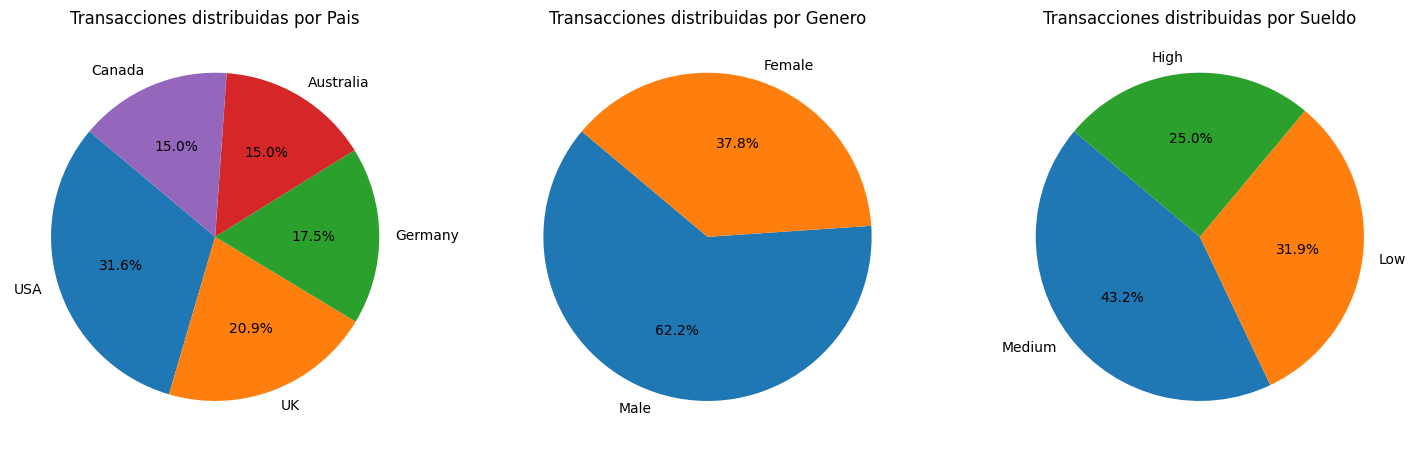

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

country = df['Country'].value_counts().to_pandas()
gender = df['Gender'].value_counts().to_pandas()
income = df['Income'].value_counts().to_pandas()

axes[0].pie(country, labels=country.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Transacciones distribuidas por Pais')

axes[1].pie(gender, labels=gender.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Transacciones distribuidas por Genero')

axes[2].pie(income, labels=income.index, autopct='%1.1f%%', startangle=140)
axes[2].set_title('Transacciones distribuidas por Sueldo')



### Interferencia-1

- La mayoria de las transacciones se hacen desde Estados Unidos
- Es mayoritaria la cantidad de Hombres haciendo transacciones
- Las personas con un salario medio hicieron mas transacciones

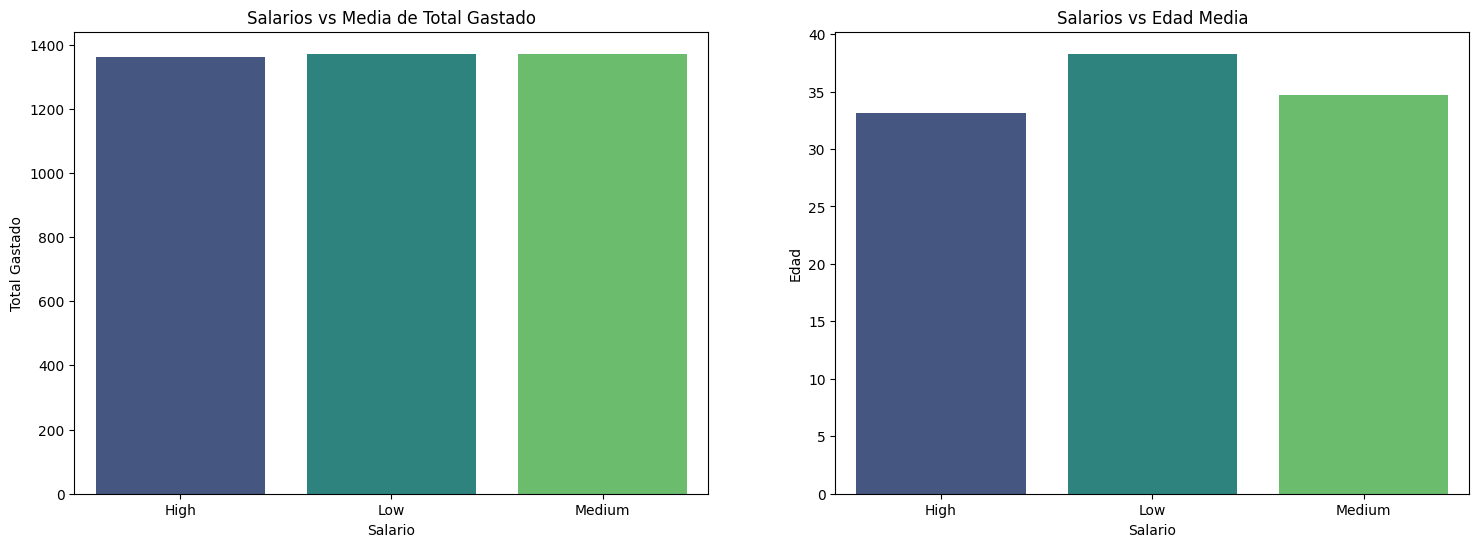

In [16]:
plot1_pandas = df.groupby('Income')['Total_Amount'].mean().to_pandas()
plot2_pandas = df.groupby('Income')['Age'].mean().to_pandas()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(plot1_pandas, palette='viridis', ax=axes[0])
axes[0].set_title('Salarios vs Media de Total Gastado')
axes[0].set_xlabel('Salario')
axes[0].set_ylabel('Total Gastado')

sns.barplot(plot2_pandas, palette='viridis', ax=axes[1])
axes[1].set_title('Salarios vs Edad Media')
axes[1].set_xlabel('Salario')
axes[1].set_ylabel('Edad')

plt.show()

### Interferencia-2

- La diferencia entre la media de lo gastado y el salario es totalmente marginal.
- La media de edad es mas baja para salarios altos y mayor para salarios menores.

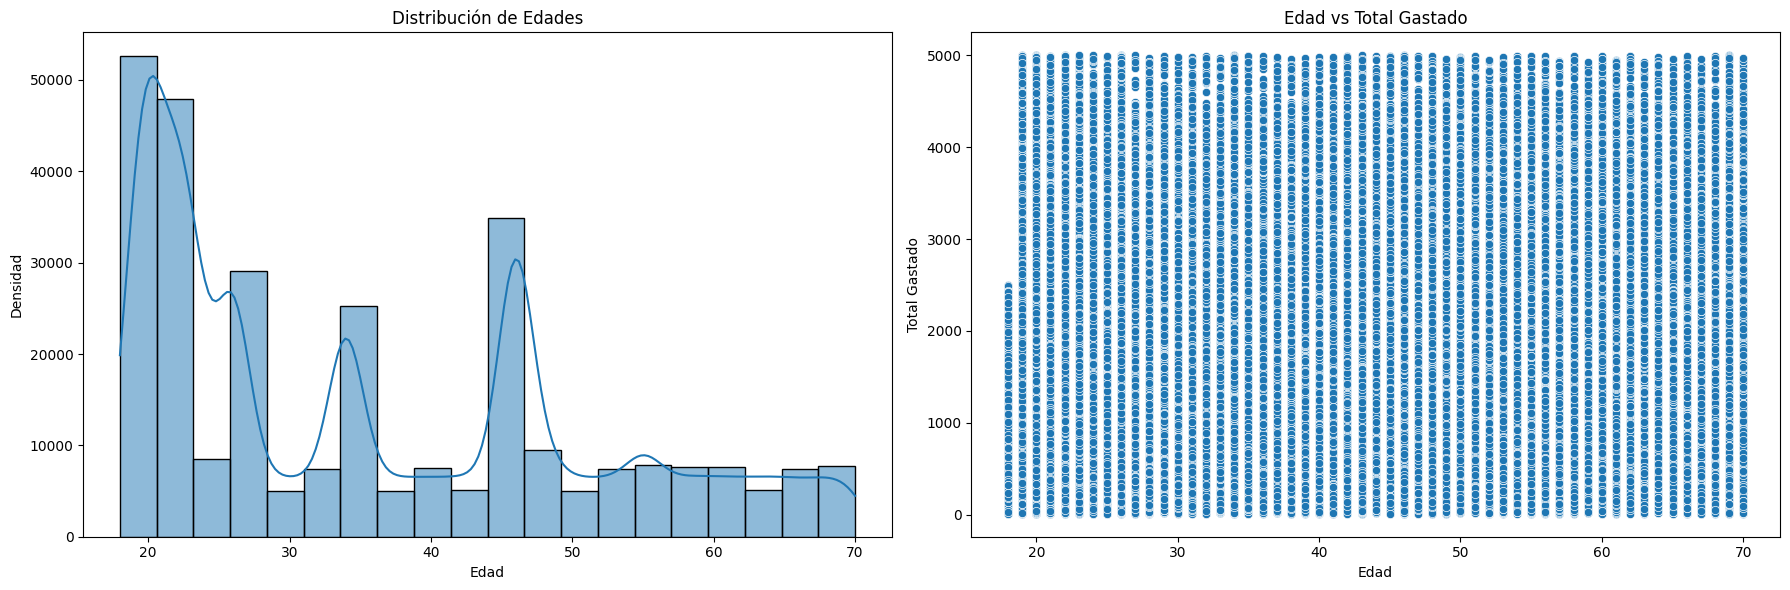

In [17]:
df_pandas_age = df["Age"].to_pandas()
df_pandas_age_amount = df[["Age", "Total_Amount"]].to_pandas()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(df_pandas_age, bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribución de Edades')
axes[0].set_xlabel('Edad')
axes[0].set_ylabel('Densidad')

sns.scatterplot(x="Age", y="Total_Amount", data=df_pandas_age_amount, ax=axes[1])
axes[1].set_title('Edad vs Total Gastado')
axes[1].set_xlabel('Edad')
axes[1].set_ylabel('Total Gastado')

plt.tight_layout()
plt.show()


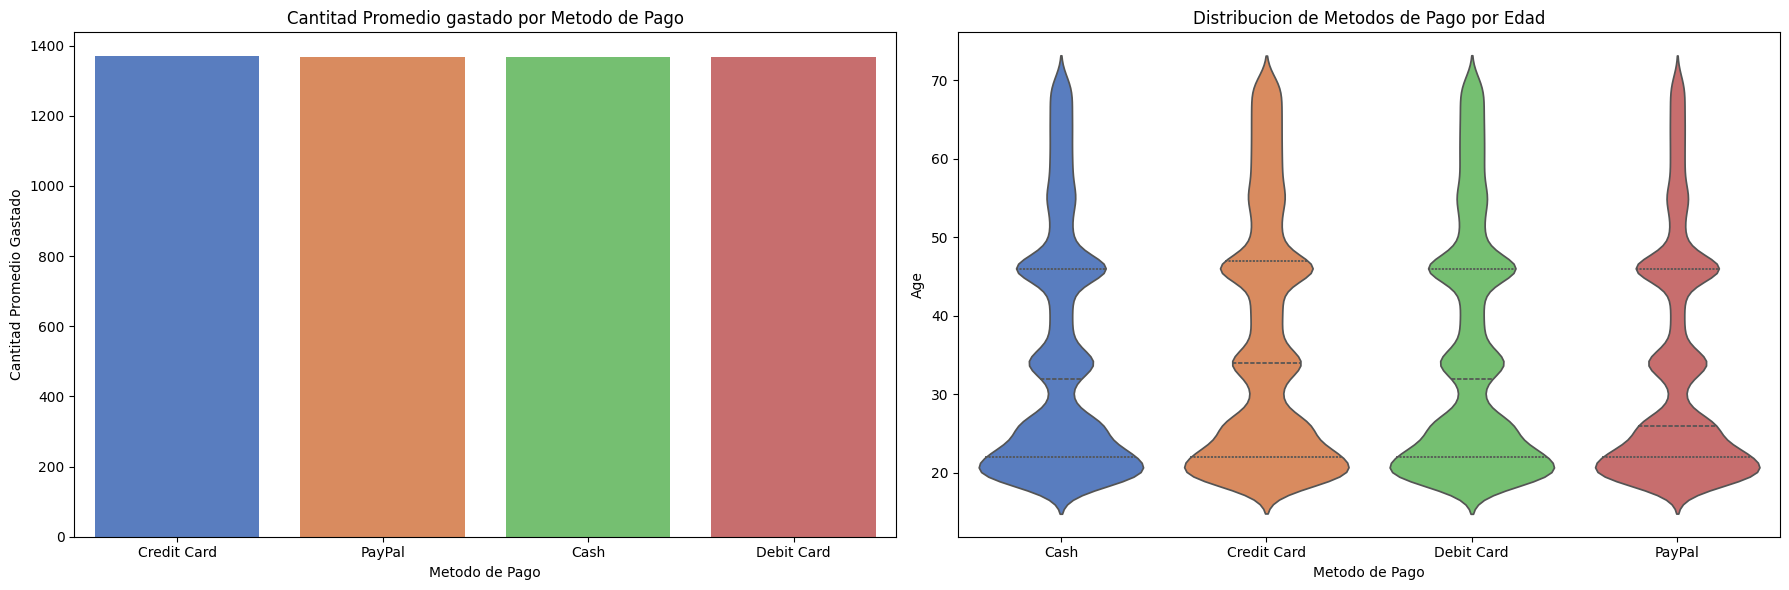

In [18]:
df_pandas_amount = df.groupby('Payment_Method')['Total_Amount'].mean().to_pandas().reset_index()
df_pandas_age = df[["Age", "Payment_Method"]].to_pandas()

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the average amount spent by payment method
sns.barplot(x='Payment_Method', y='Total_Amount', data=df_pandas_amount, palette='muted', ax=axes[0])
axes[0].set_title('Cantitad Promedio gastado por Metodo de Pago')
axes[0].set_xlabel('Metodo de Pago')
axes[0].set_ylabel('Cantitad Promedio Gastado')

# Plot the distribution of payment methods by age
sns.violinplot(x='Payment_Method', y='Age', data=df_pandas_age, inner='quartile', palette='muted', ax=axes[1])
axes[1].set_title('Distribucion de Metodos de Pago por Edad')
axes[1].set_xlabel('Metodo de Pago')
axes[1].set_ylabel('Age')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### Inferencia-3

- Las edades son bastante distribuidas pero hay un poco mas de gente joven.
- La cantidad gastada no influye en el metodo de pago, a diferencia de lo que pensaba.
- La gente menor suele usar mucho mas medios de pago como PayPal.

Text(0.5, 1.0, 'Transacciones distribuidas por Metodo de Pago')

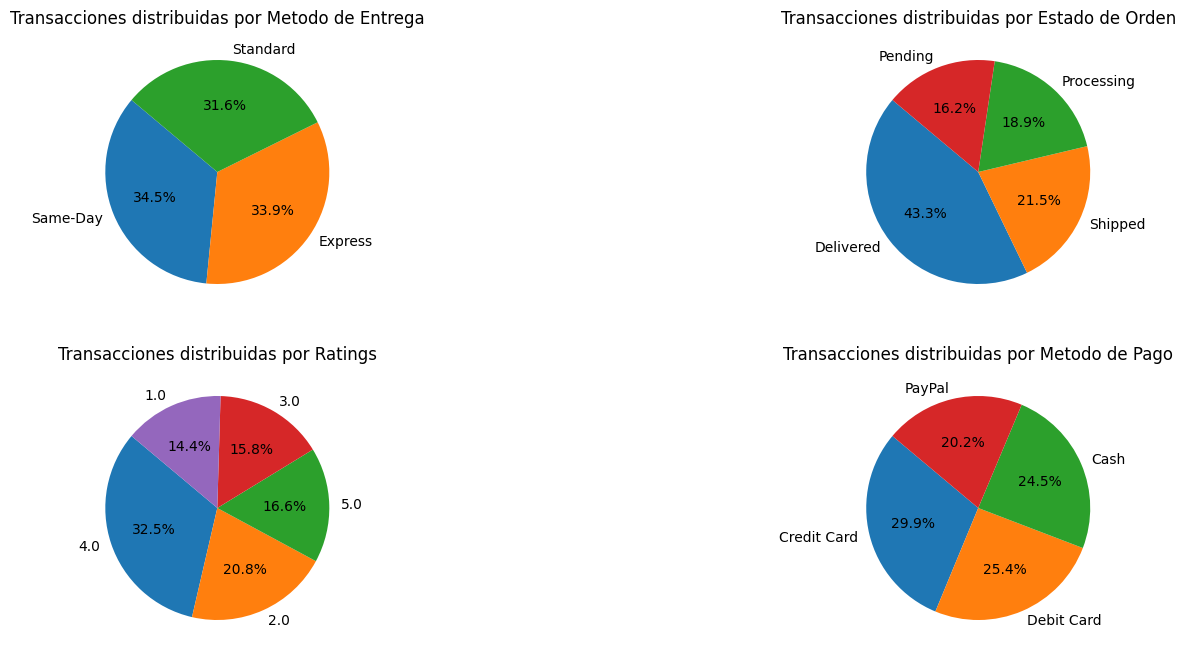

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(18, 8))

shipping_method = df['Shipping_Method'].value_counts().to_pandas()
order_status = df['Order_Status'].value_counts().to_pandas()
ratings = df['Ratings'].value_counts().to_pandas()
payment_method = df['Payment_Method'].value_counts().to_pandas()


axes[0, 0].pie(shipping_method, labels=shipping_method.index, autopct='%1.1f%%', startangle=140)
axes[0, 0].set_title('Transacciones distribuidas por Metodo de Entrega')

axes[0, 1].pie(order_status, labels=order_status.index, autopct='%1.1f%%', startangle=140)
axes[0, 1].set_title('Transacciones distribuidas por Estado de Orden')

axes[1, 0].pie(ratings, labels=ratings.index, autopct='%1.1f%%', startangle=140)
axes[1, 0].set_title('Transacciones distribuidas por Ratings')

axes[1, 1].pie(payment_method, labels=payment_method.index, autopct='%1.1f%%', startangle=140)
axes[1, 1].set_title('Transacciones distribuidas por Metodo de Pago')

### Inferencia-4

- Los 3 metodos de entrega son igual de populares.
- La mayoria de los productos fueron ya entregados, pero de igual manera hay una cantidad bastante alta en pendientes.
- Las tarjetas son mas usadas que los otros metodos de pago.
- Las reseñas suelen ser bastante positivas, solamente un 35% son negativas (1 y 2 estrellas).

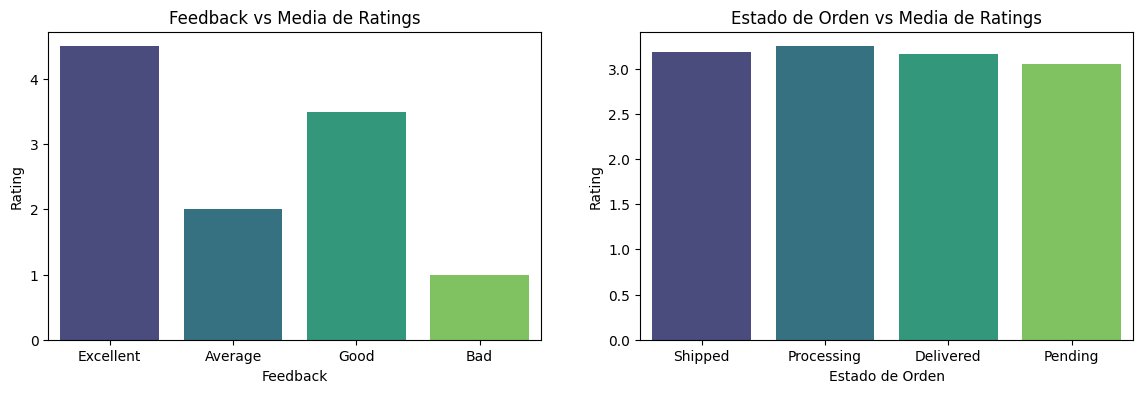

In [20]:
plot1_pandas = df.groupby('Feedback')['Ratings'].mean().to_pandas()
plot2_pandas = df.groupby('Order_Status')['Ratings'].mean().to_pandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.barplot(plot1_pandas, palette='viridis', ax=axes[0])
axes[0].set_title('Feedback vs Media de Ratings')
axes[0].set_xlabel('Feedback')
axes[0].set_ylabel('Rating')

sns.barplot(plot2_pandas, palette='viridis', ax=axes[1])
axes[1].set_title('Estado de Orden vs Media de Ratings')
axes[1].set_xlabel('Estado de Orden')
axes[1].set_ylabel('Rating')

plt.show()

### Inferencia-5

- El feedback va de la mano con las reseñas.
- Las ordenes pendientes tienen peores reseñas pero no tan malas como uno espera.

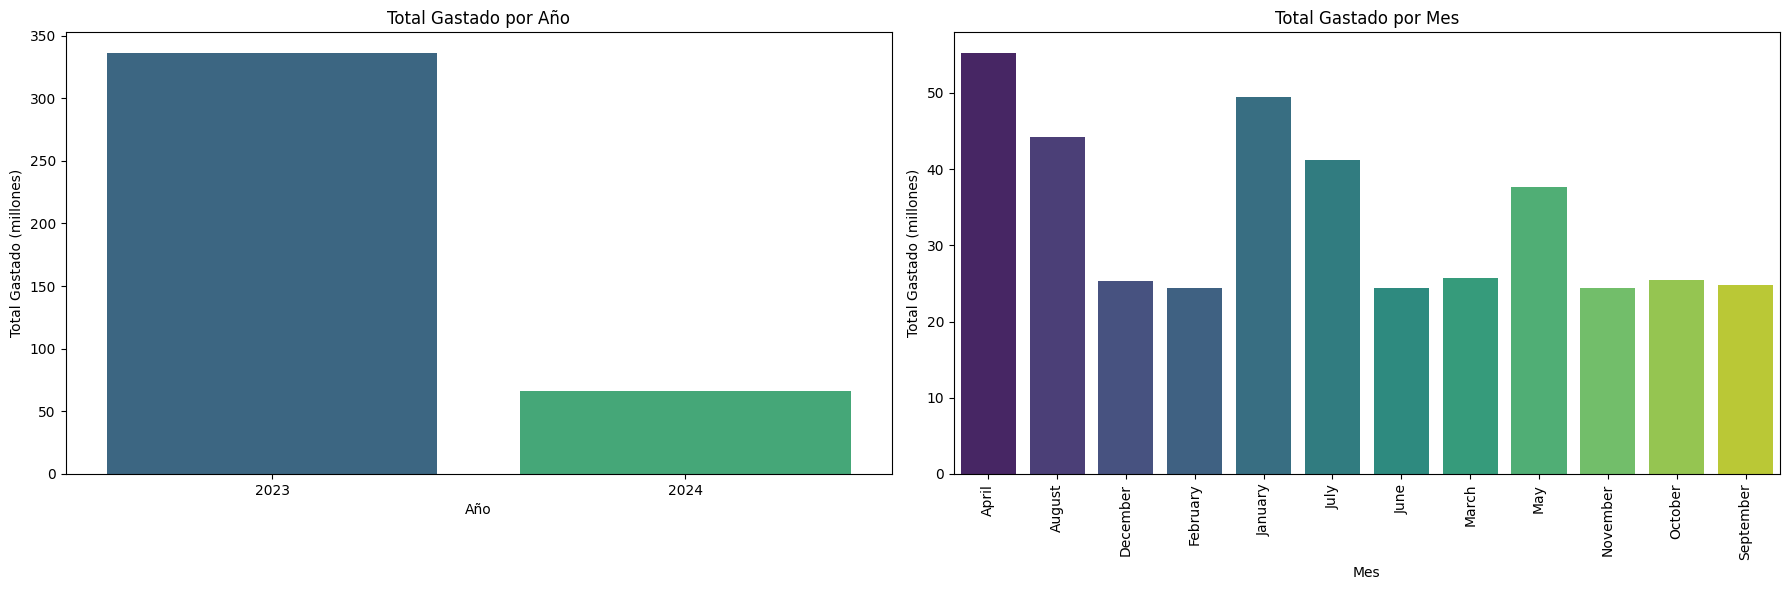

In [21]:
plot1_pandas = df.groupby('Year')['Total_Amount'].sum().to_pandas()
plot2_pandas = df.groupby('Month')['Total_Amount'].sum().to_pandas()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(x=plot1_pandas.index.astype(int), y=plot1_pandas.values / 1e6, palette='viridis', ax=axes[0])
axes[0].set_title('Total Gastado por Año')
axes[0].set_xlabel('Año')
axes[0].set_ylabel('Total Gastado (millones)')

# Gráfico de barras para el total gastado por mes
sns.barplot(x=plot2_pandas.index, y=plot2_pandas.values / 1e6, palette='viridis', ax=axes[1])
axes[1].set_title('Total Gastado por Mes')
axes[1].set_xlabel('Mes')
axes[1].set_ylabel('Total Gastado (millones)')
axes[1].tick_params(axis='x', rotation=90)  # Rotar las etiquetas de los meses

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

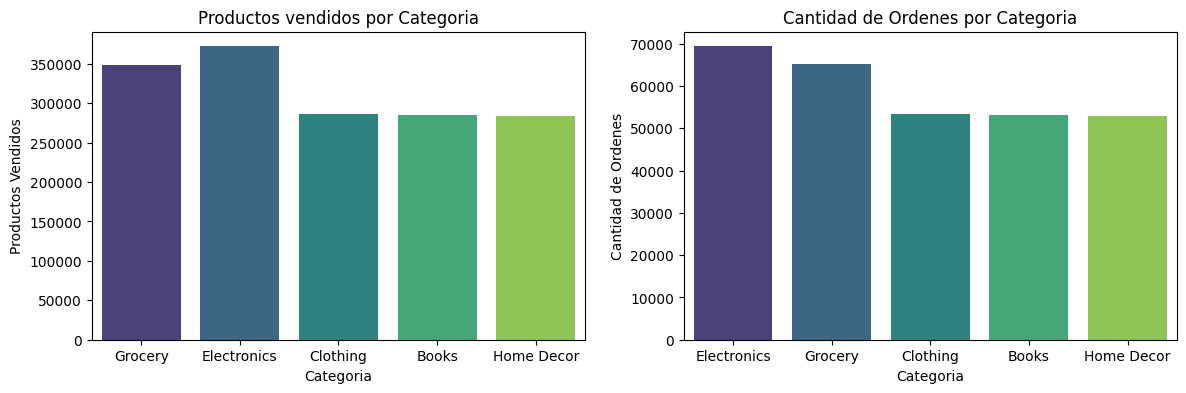

In [22]:
plot1_pandas = df.groupby('Product_Category')['Total_Purchases'].sum().to_pandas()
plot2_pandas = df['Product_Category'].value_counts().to_pandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.barplot(plot1_pandas, palette='viridis', ax=axes[0])
axes[0].set_title('Productos vendidos por Categoria')
axes[0].set_xlabel('Categoria')
axes[0].set_ylabel('Productos Vendidos')

sns.barplot(plot2_pandas, palette='viridis', ax=axes[1])
axes[1].set_title('Cantidad de Ordenes por Categoria')
axes[1].set_xlabel('Categoria')
axes[1].set_ylabel('Cantidad de Ordenes')

plt.show()

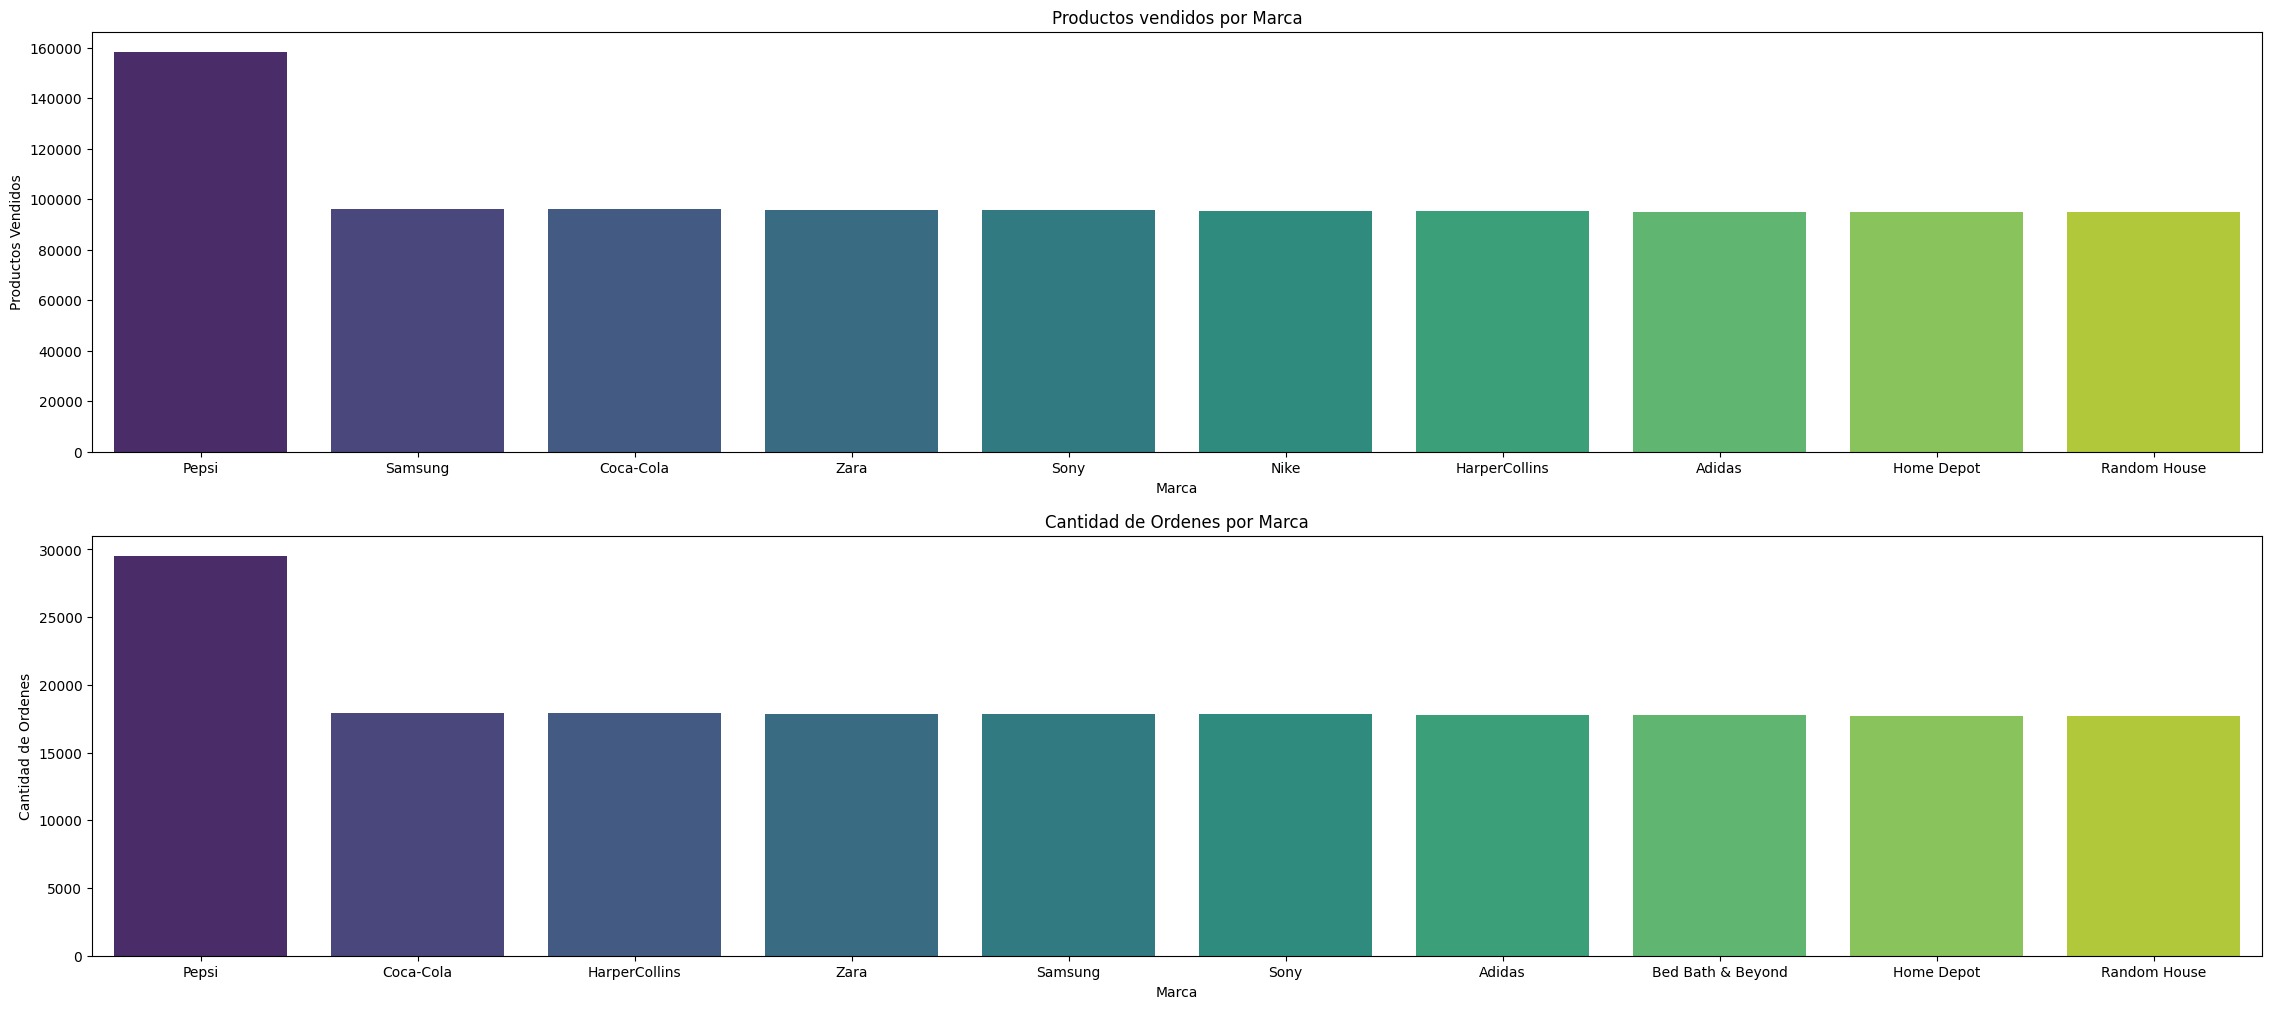

In [23]:
plot1_pandas = df.groupby('Product_Brand')['Total_Purchases'].sum().sort_values(ascending=False).head(10).to_pandas()
plot2_pandas = df['Product_Brand'].value_counts().sort_values(ascending=False).head(10).to_pandas()

fig, axes = plt.subplots(2, 1, figsize=(28, 12))

sns.barplot(plot1_pandas, palette='viridis', ax=axes[0])
axes[0].set_title('Productos vendidos por Marca')
axes[0].set_xlabel('Marca')
axes[0].set_ylabel('Productos Vendidos')

sns.barplot(plot2_pandas, palette='viridis', ax=axes[1])
axes[1].set_title('Cantidad de Ordenes por Marca')
axes[1].set_xlabel('Marca')
axes[1].set_ylabel('Cantidad de Ordenes')

plt.show()

### Inferenencia - 6

- Hay una gran cantidad de productos vendidos en la categoria electronicos, sorprendentemente supera a las golocinas.
- Con bastante diferencia la marca mas vendida es Pepsi.

## Interferencia Final:

- Las transacciones comerciales en la base de datos muestran una clara predominancia de Estados Unidos como el principal origen de compras. El perfil de los consumidores revela una mayoría masculina, con una tendencia a que personas con un salario medio realicen más transacciones. Aunque la diferencia entre el gasto medio y el salario es marginal, se observa que las personas con salarios más altos tienden a ser más jóvenes, mientras que los individuos con salarios más bajos son, en promedio, mayores.
    
- La distribución de edades es relativamente uniforme, aunque hay una ligera inclinación hacia los consumidores más jóvenes. La cantidad gastada por los consumidores no parece tener un impacto significativo en la elección del método de pago, aunque los consumidores jóvenes prefieren significativamente el uso de PayPal. En cuanto a los métodos de entrega, todos los métodos son igualmente populares, y mientras que la mayoría de los productos se entregan a tiempo, aún existe una cantidad considerable de pedidos pendientes. Las tarjetas de crédito son el método de pago más común, y las reseñas son predominantemente positivas, con un 35% de reseñas negativas.
    
- El feedback de los clientes refleja en gran medida las reseñas, con las órdenes pendientes recibiendo peores reseñas, aunque no tan severas como se podría esperar. Además, la categoría de productos electrónicos supera en ventas a las golosinas, y Pepsi se destaca como la marca más vendida.
    
#### En resumen, el análisis muestra una robusta relación entre características demográficas y comportamientos de compra, con preferencias de pago y métodos de entrega que se alinean con las expectativas, y una notable inclinación hacia productos electrónicos y la marca Pepsi.